In [1]:
from nltk import download as nltk_download

nltk_download('punkt')
nltk_download('averaged_perceptron_tagger')
nltk_download('wordnet')

[nltk_data] Downloading package punkt to /Users/amy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/amy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from bs4 import BeautifulSoup as Soup
from itertools import islice
import json
import logging
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from os import path
from PyPDF2 import PdfReader
import string
from typing import Iterable, List, Tuple

lem = WordNetLemmatizer()

logger = logging.getLogger("PyPDF2")
logger.setLevel(logging.ERROR)

def load_custom_stopwords() -> List[str]:
    custom_stopwords = []
    with open('custom_stopwords.json', 'r') as f:
        return json.load(f)

def extract_html_tokens(file_path: str) -> str:
    soup = None
    with open(file_path, 'rb') as f:
        soup = Soup(f, 'html.parser')

    for script in soup(["script", "style"]):
        script.extract()

    return soup.get_text()

def extract_pdf_tokens(file_path: str) -> str:
    text = ''
    reader = PdfReader(file_path)
    for page in reader.pages:
        text = text + "\n" + page.extract_text()

    return text

def extract_tokens(file_path: str) -> Iterable[str]:
    EXTRACTORS = {
        '.html': extract_html_tokens,
        '.pdf': extract_pdf_tokens,
    }
    
    try:
        extension = path.splitext(file_path)[-1].lower()
        text = EXTRACTORS[extension](file_path)

        text = (
            text
                .replace('—', '-')
                .replace('“', '"')
                .replace('”', '"')
                .replace('’', '\'')
        )
        
        return (token.lower().strip(string.punctuation) for token in word_tokenize(text) if token not in string.punctuation)
    except Exception as e:
        print(f'Failed to extract {file_path}: {type(e).__name__}')
        return []
    

def retag_for_wordnet(tagged_pair: Tuple[str, str]) -> Tuple[str, str]:
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    word, tag = tagged_pair
    return (word, get_wordnet_pos(tag))

def canonicalize_tokens(tokens: Iterable[str]) -> Iterable[str]:
    tagged = pos_tag(list(tokens))
    retagged = (retag_for_wordnet(tagpair) for tagpair in tagged)
    return (lem.lemmatize(*tagpair) for tagpair in retagged)

def process_file(file_path: str) -> Iterable[str]:
    return canonicalize_tokens(extract_tokens(file_path))

In [3]:
from glob import glob
from itertools import chain, islice

file_path = 'bills/FL_S0254.html'

bills = glob('bills/*')

canonicalized_tokens = chain.from_iterable(
    process_file(bill)
    for bill
    in bills
)

In [4]:
corpus = ' '.join(canonicalized_tokens)

Failed to extract bills/empty: KeyError


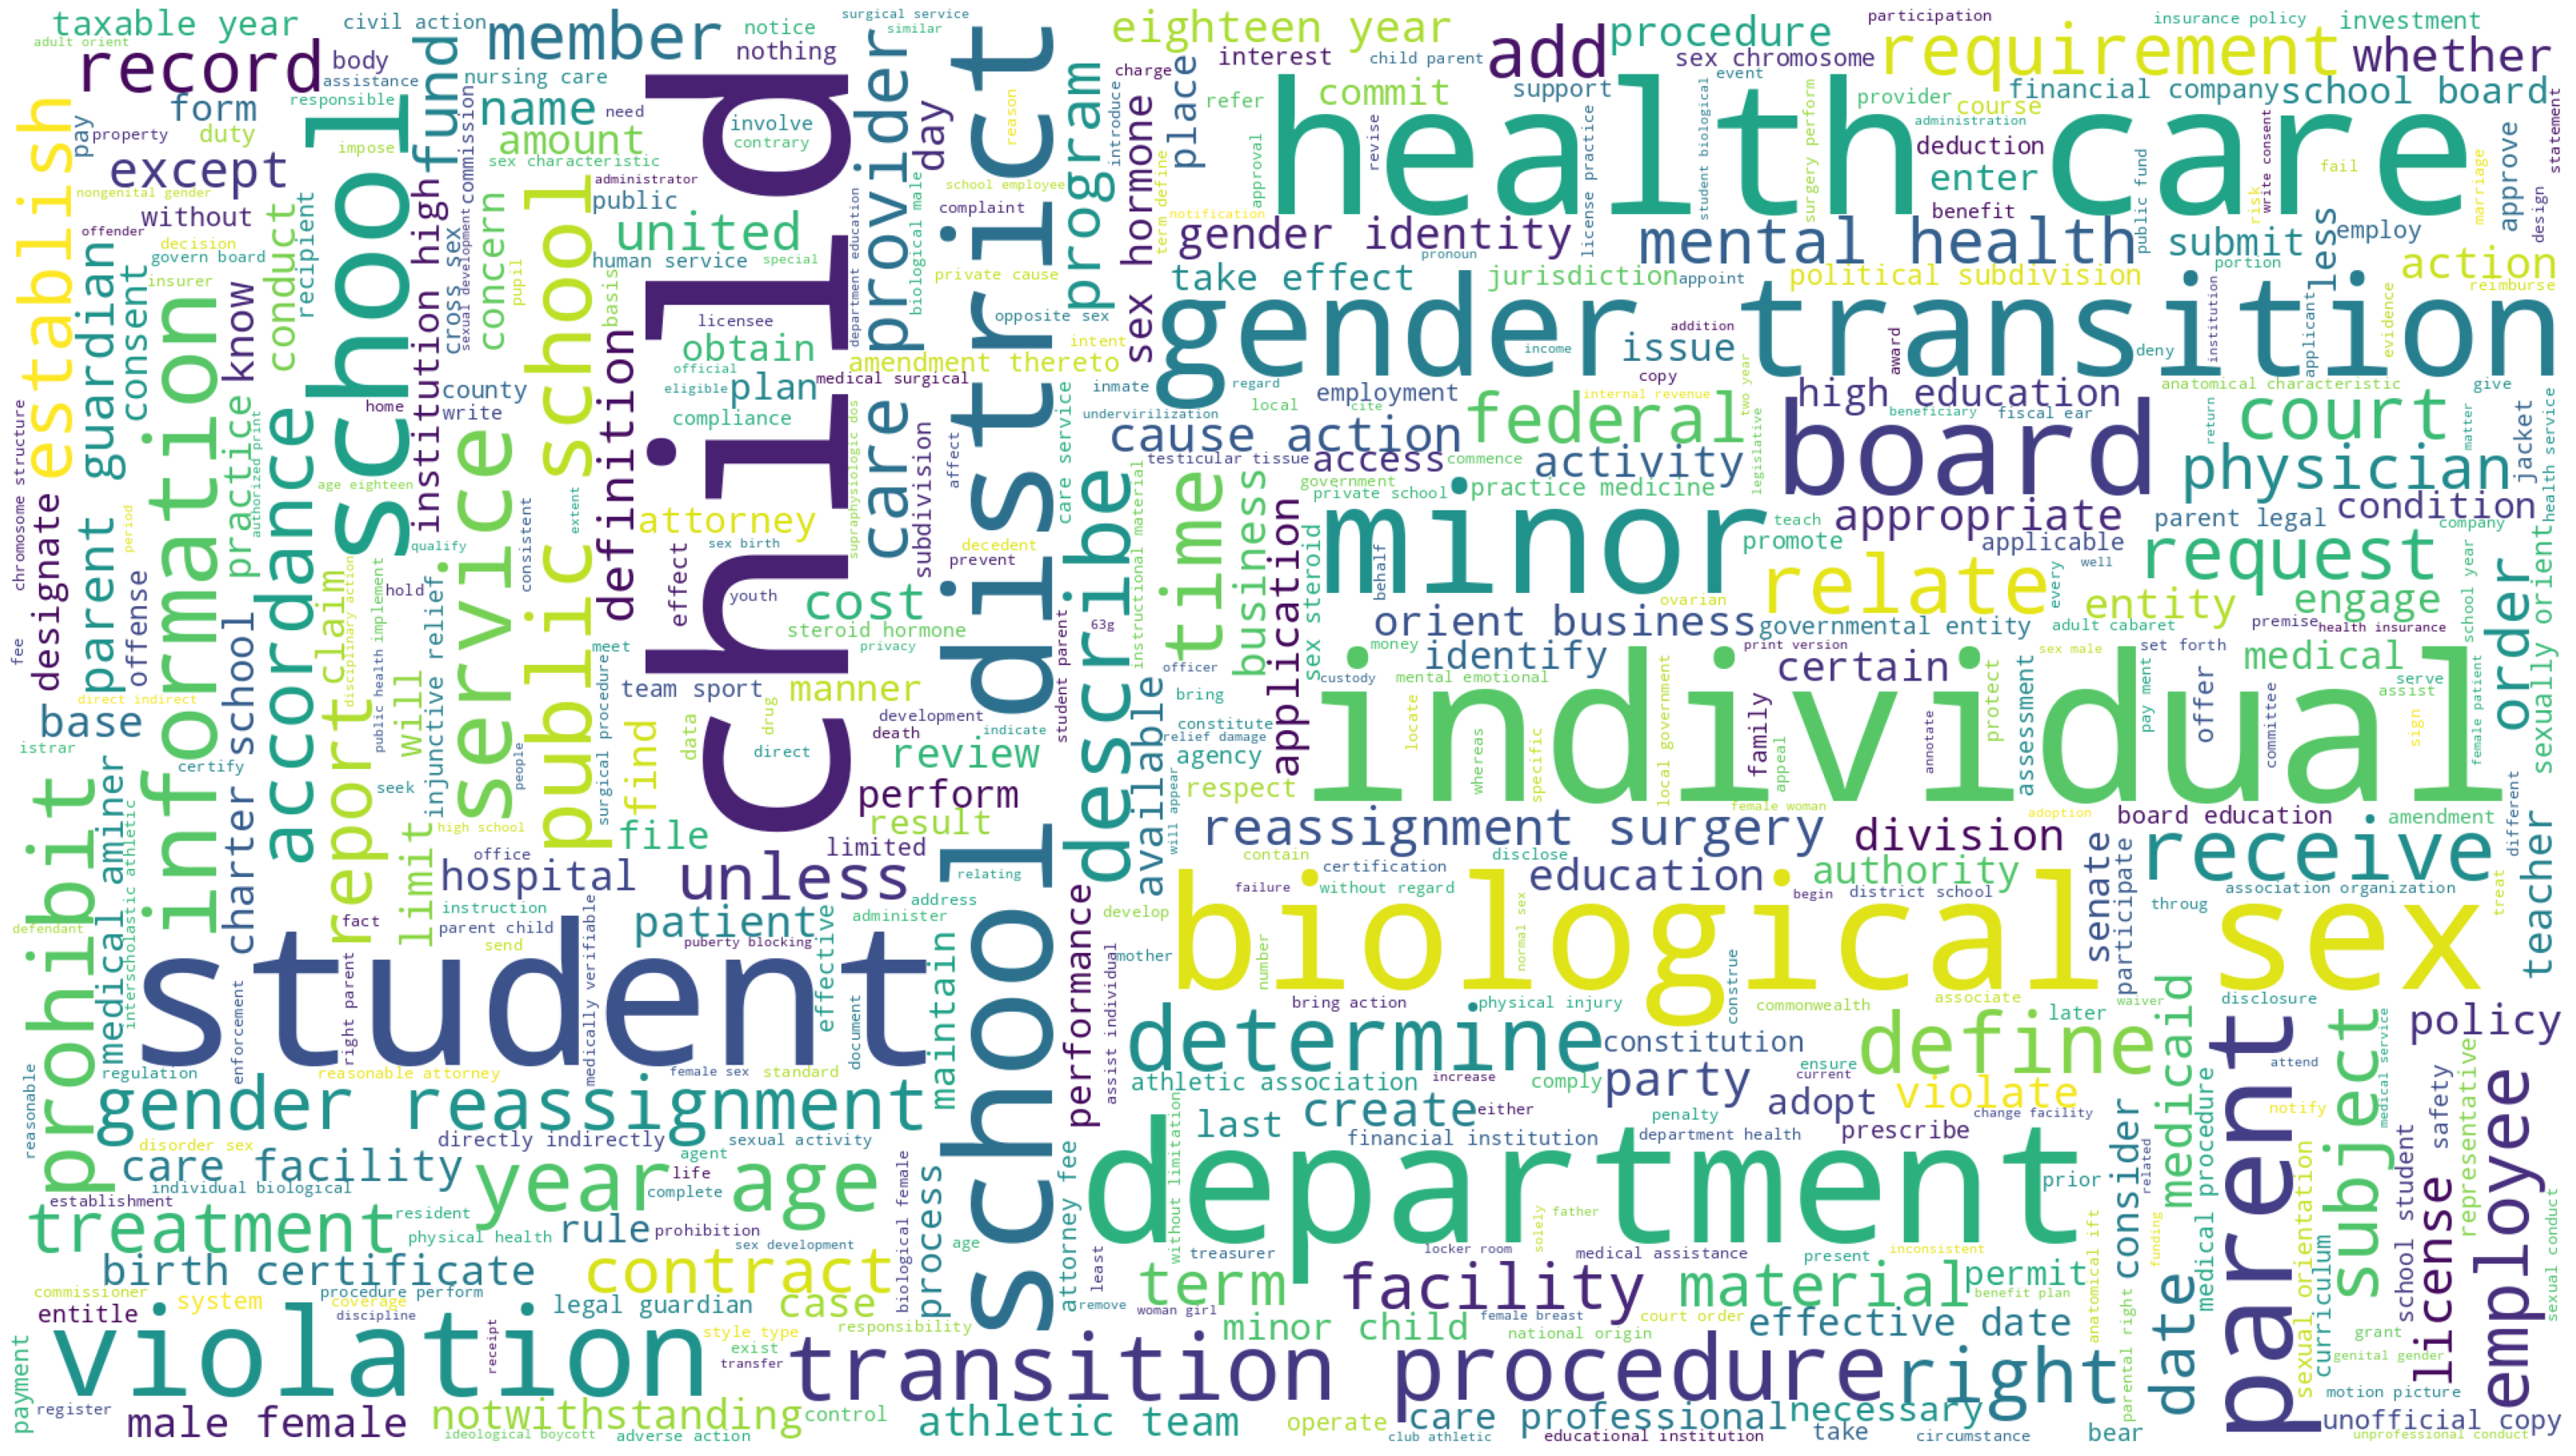

In [5]:
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

STOPWORDS.update(load_custom_stopwords())

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
#supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
# 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 
# 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 
# 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
# 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 
# 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 
# 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 
# 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 
# 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 
# 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 
# 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 
# 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
# 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

# Generate word cloud
wordcloud = WordCloud(
    width=1920, 
    height=1080,
    random_state=2, 
    background_color='white', 
    colormap='viridis', 
    collocations=True,
    collocation_threshold=30,
    stopwords=STOPWORDS,
    max_words=1000,
    min_word_length=3,
    max_font_size=200,
    min_font_size=10,
    relative_scaling=0.8,
    prefer_horizontal=0.7,
)

wordcloud_plot = wordcloud.generate(corpus)

# Plot
wordcloud_plot.to_file('cloud.png')
plot_cloud(wordcloud_plot)